# **HDA Project**


## Base configuration

###Colab environment machine information

In [ ]:
import os
import tensorflow as tf
# Detect hardware
try:
  # TPU detection, TPU are performant GPU cluster but is complex to handle
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() 
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
  !nvidia-smi
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Wed Jan 27 14:20:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    34W /  70W |   1021MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                   

###Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import csv
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from IPython.display import SVG
%load_ext tensorboard

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import Image

!pip install parse
!pip install split-folders
import parse

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


###mount Google Drive and setup work folder 
Remember to split the dataset with split-folders with 

```
import splitfolders

splitfolders.ratio("dataset", output="dataset_splitted", seed=1337, ratio=(.8, .1, .1), group_prefix=None)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics'
os.chdir(PATH)
print('The work is in path:', os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The work is in path: /content/drive/MyDrive/Colab Notebooks/Human Data Analytics


##Data setup and manipulation

###General Data Information

In [ ]:
image_size = (1388, 1040)
input_shape = (224, 224, 3)
num_classes = 3

### Load data images and save patches to TFRecords files on local runtime

In [ ]:
#Parameters for patches extraction
patches_size=(347,260)
patches_size_x, patches_size_y = patches_size
patches_stride_x, patches_stride_y = patches_size
test_patches_size_x, test_patches_size_y = patches_size
test_patches_stride_x, test_patches_stride_y = patches_size

dataset_path_train = os.path.join(os.getcwd(),'dataset/train')
dataset_path_val = os.path.join(os.getcwd(),'dataset/val')
dataset_path_test = os.path.join(os.getcwd(),'dataset/test')
save_path_TFRecords_train = '/content/train_patches.tfrecord'
save_path_TFRecords_val = '/content/val_patches.tfrecord'
save_path_TFRecords_test = '/content/test_patches.tfrecord'

already_exist=os.path.exists(save_path_TFRecords_train)
already_exist=already_exist and os.path.exists(save_path_TFRecords_val)
already_exist=already_exist and os.path.exists(save_path_TFRecords_test)

if not already_exist:
  img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, )
  train_generator = img_gen.flow_from_directory(dataset_path_train ,shuffle=True, target_size=image_size, batch_size=1)
  val_generator = img_gen.flow_from_directory(dataset_path_val ,shuffle=False, target_size=image_size, batch_size=1)
  test_generator = img_gen.flow_from_directory(dataset_path_test ,shuffle=False, target_size=image_size, batch_size=1)
  
  #TRAIN PATCHES
  with tf.io.TFRecordWriter(save_path_TFRecords_train) as writer:    
    for i in range(len(train_generator)):
      element = next(train_generator)
      image = element[0]
      label = element[1][0]
      patchedImage = tf.image.extract_patches(image,sizes=[1,patches_size_x,patches_size_y,1],
                                              strides=[1,patches_stride_x,patches_stride_y,1],
                                              rates=[1, 1, 1, 1],
                                              padding='VALID')
      patchedImage = tf.reshape(patchedImage,[-1,patches_size_x,patches_size_y,3]).numpy()
      for k,patch in enumerate(patchedImage):
        def _bytes_feature(value):
          """Returns a bytes_list from a string / byte."""
          if isinstance(value, type(tf.constant(0))): # if value is tensor
              value = value.numpy() # get value of tensor
          return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
        
        serialized_patch, serialized_label = tf.io.serialize_tensor(patch), tf.io.serialize_tensor(label)
        feature = {'patch': _bytes_feature(serialized_patch),
                    'label': _bytes_feature(serialized_label)}
        example_message = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example_message.SerializeToString())

  #VALIDATION PATCHES
  with tf.io.TFRecordWriter(save_path_TFRecords_val) as writer:    
    for i in range(len(val_generator)):
      element = next(val_generator)
      image = element[0]
      label = element[1][0]
      patchedImage = tf.image.extract_patches(image,sizes=[1,patches_size_x,patches_size_y,1],
                                              strides=[1,patches_stride_x,patches_stride_y,1],
                                              rates=[1, 1, 1, 1],
                                              padding='VALID')
      patchedImage = tf.reshape(patchedImage,[-1,patches_size_x,patches_size_y,3]).numpy()
      for k,patch in enumerate(patchedImage):
        def _bytes_feature(value):
          """Returns a bytes_list from a string / byte."""
          if isinstance(value, type(tf.constant(0))): # if value is tensor
              value = value.numpy() # get value of tensor
          return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
        
        serialized_patch, serialized_label = tf.io.serialize_tensor(patch), tf.io.serialize_tensor(label)
        feature = {'patch': _bytes_feature(serialized_patch),
                    'label': _bytes_feature(serialized_label)}
        example_message = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example_message.SerializeToString())

  #TEST PATCHES
  with tf.io.TFRecordWriter(save_path_TFRecords_test) as writer:    
    for i in range(len(test_generator)):
      element = next(test_generator)
      image = element[0]
      label = element[1][0]
      patchedImage = tf.image.extract_patches(image,sizes=[1,test_patches_size_x, test_patches_size_y,1],
                                              strides=[1,test_patches_stride_x, test_patches_stride_y,1],
                                              rates=[1, 1, 1, 1],
                                              padding='VALID')
      patchedImage = tf.reshape(patchedImage,[-1,test_patches_size_x, test_patches_size_y,3]).numpy()
      for k,patch in enumerate(patchedImage):
        def _bytes_feature(value):
          """Returns a bytes_list from a string / byte."""
          if isinstance(value, type(tf.constant(0))): # if value is tensor
              value = value.numpy() # get value of tensor
          return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
        
        serialized_patch, serialized_label = tf.io.serialize_tensor(patch), tf.io.serialize_tensor(label)
        feature = {'patch': _bytes_feature(serialized_patch),
                    'label': _bytes_feature(serialized_label)}
        example_message = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example_message.SerializeToString())
      

###Generate datasets from TFRecord file

In [ ]:
def _reconstruct_element(element):
  parse_dic = {
    'patch': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.string),
    }
  example_message = tf.io.parse_single_example(element, parse_dic)
  patch = tf.io.parse_tensor(example_message['patch'], out_type=tf.float32)
  patch = tf.image.random_crop(patch, size=input_shape)
  label = tf.io.parse_tensor(example_message['label'], out_type=tf.float32)
  label = tf.reshape(label,((num_classes,-1)))
  return patch,label

train_dataset_base = tf.data.TFRecordDataset(save_path_TFRecords_train) 
train_dataset_base = train_dataset_base.map(_reconstruct_element).cache()

val_dataset_base = tf.data.TFRecordDataset(save_path_TFRecords_val) 
val_dataset_base = val_dataset_base.map(_reconstruct_element).cache()

test_dataset_base = tf.data.TFRecordDataset(save_path_TFRecords_test) 
test_dataset_base = test_dataset_base.map(_reconstruct_element).cache()

##Models configuration

###AlexNet Class

In [ ]:
def Alexnet(input_shape, num_classes, name='Alexnet'):
     
    X_input = Input(input_shape)

    # Convolution Layer with 32 filters and a kernel size of 5.
    X = Conv2D(32, kernel_size=5, activation=tf.nn.relu, name='conv1')(X_input)
    # Max Pooling (down-sampling) with kernel size of 3 and strides of 2. 
    X = MaxPooling2D(3, strides=1, name='max_pool1')(X)

    # Convolution Layer with 32 filters and a kernel size of 5.
    X = Conv2D(32, kernel_size=5, activation=tf.nn.relu, name='conv2')(X)
    # Avg Pooling (down-sampling) with kernel size of 3 and strides of 2. 
    X = AveragePooling2D(3, strides=1, name='avg_pool2')(X)

    # Convolution Layer with 64 filters and a kernel size of 5.
    X = Conv2D(64, kernel_size=5, activation=tf.nn.relu, name='conv3')(X)
    # Avg Pooling (down-sampling) with kernel size of 3 and strides of 2. 
    X = AveragePooling2D(3, strides=1, name='avg_pool3')(X)
    
    # Fully connected layers, with dropout
    X = Flatten()(X)
    X = Dense(64, activation='relu', name='fc1')(X)
    X = Dropout(0.3)(X)
    out = Dense(num_classes, activation= 'softmax',name='out')(X)
    
    # Create Keras model instance, used to train/test the model.
    model = Model(inputs = X_input, outputs = out, name=name)
     
    return model

###CNN Model

In [ ]:
def CNN5(input_shape, num_classes, name='CNN5'):
        
    X_input = Input(input_shape)

    X = Conv2D(16, kernel_size=5, activation=tf.nn.leaky_relu, name='conv1')(X_input)
    X = MaxPooling2D(2, strides=2, name='max_pool1')(X)

    X = Conv2D(32, kernel_size=5, activation=tf.nn.leaky_relu, name='conv2')(X)
    X = MaxPooling2D(2, strides=2, name='max_pool2')(X)

    X = Conv2D(64, kernel_size=5, activation=tf.nn.leaky_relu, name='conv3')(X)
    X = MaxPooling2D(2, strides=2, name='max_pool3')(X)

    X = Conv2D(64, kernel_size=5, activation=tf.nn.leaky_relu, name='conv4')(X)
    X = MaxPooling2D(2, strides=2, name='max_pool4')(X)

    X = Conv2D(64, kernel_size=5, activation=tf.nn.leaky_relu, name='conv5')(X)
    X = MaxPooling2D(2, strides=2, name='max_pool5')(X)
    
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc1')(X)
    X = Dropout(0.3)(X)
    out = Dense(num_classes, activation= 'softmax',name='out')(X)

    model = Model(inputs = X_input, outputs = out, name=name)
     
    return model

def CNN10(input_shape, num_classes, name='CNN10'):
        
    X_input = Input(input_shape)

    X = Conv2D(16, kernel_size=5, activation=tf.nn.relu, name='conv1')(X_input)
    X = MaxPooling2D(2, strides=2, name='max_pool1')(X)

    X = Conv2D(32, kernel_size=5, activation=tf.nn.relu, name='conv2')(X)
    X = MaxPooling2D(2, strides=2, name='max_pool2')(X)

    for i in range(8):
      X = Conv2D(64, kernel_size=5, activation=tf.nn.relu, name='conv{}'.format(i+3))(X)
      X = MaxPooling2D(2, strides=1, name='max_pool{}'.format(i+3))(X)
    
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc1')(X)
    X = Dropout(0.3)(X)
    out = Dense(num_classes, activation= 'softmax',name='out')(X)
    
    model = Model(inputs = X_input, outputs = out, name=name)
     
    return model

###InceptionV3 Class

In [ ]:
def InceptionV3(input_shape, num_classes, name='InceptionV3'):
    base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Let's add a fully-connected layer
    x = layers.Dense(75, activation='relu')(x)

    # Now a dropout layer
    x = layers.Dropout(0.3)(x)

    # And a logistic layer
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=out, name='InceptionV3')
    return model

###Models Configuration

In [ ]:
mods=['CNN5']
optims=['Adagrad','SGD','Adam']
learning_rates=[1e-3,1e-4]
batch_sizes=[64,128]
model_names=[]

with strategy.scope():
  for mod in mods:
    for opt in optims:
      for lr in learning_rates:
        for batch_size in batch_sizes:
          model_name='{}-{}_{}_{}_{}'.format(mod,input_shape[0],opt,lr,batch_size)
          if mod == 'Alexnet':
            model=Alexnet(input_shape=input_shape, num_classes=num_classes, name=model_name)
          if mod == 'InceptionV3':
            model=InceptionV3(input_shape=input_shape, num_classes=num_classes, name=model_name)
          if mod == 'ResNet50':
            model=ResNet50(input_shape=input_shape, num_classes=num_classes, name=model_name)
          if mod == 'CNN5':
            model=CNN5(input_shape=input_shape, num_classes=num_classes, name=model_name)
          if mod == 'CNN10':
            model=CNN10(input_shape=input_shape, num_classes=num_classes, name=model_name)

          optimizers={'Adagrad': keras.optimizers.Adagrad(learning_rate=lr),
                      'SGD': keras.optimizers.SGD(learning_rate=lr,momentum=0.9,nesterov=True),
                      'Adam': keras.optimizers.Adam(learning_rate=lr)}
                      
          model.compile(loss='categorical_crossentropy', 
                        optimizer=optimizers[opt], 
                        metrics=['accuracy'])
          
          checkpoint_path = os.path.join(os.getcwd(),"models/{}".format(model_name)+"/cp-{epoch:04d}.h5") 
          model_dir = os.path.dirname(checkpoint_path)
          os.makedirs(model_dir,exist_ok=True)      
          model.save(checkpoint_path.format(epoch=0))
          model_names.append(model_name)
          model.summary()

Model: "CNN5-224_Adagrad_0.001_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 110, 110, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 53, 53, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 49, 49, 64)        51264     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 24, 2

##Training

###Parameters

In [ ]:
epochs=30
base_batch=128  #reference batch size for training normalization
base_batches_processed_per_epoch=500  #reference n° of base batches processed in one epoch
save_period=10
validation_period=2
selected_start_epoch=-1 #if the related checkpoint exist, the training start from it

###Training

In [ ]:
trained_models={}
tensorboard_folders={}
for model_name in model_names: 

  #Load Model 

  checkpoint_path = os.path.join(os.getcwd(),"models/{}".format(model_name)+"/cp-{epoch:04d}.h5") 
  model_dir = os.path.dirname(checkpoint_path)
  last_epoch=-1
  for checkpoint in sorted(os.listdir(model_dir),reverse=True):
    try:  file_epoch = parse.parse(checkpoint_path, os.path.join(model_dir,checkpoint))['epoch'] 
    except : file_epoch =-1
    if selected_start_epoch>=0 and file_epoch==selected_start_epoch:
      model=keras.models.load_model(os.path.join(model_dir,checkpoint), custom_objects={'leaky_relu': tf.nn.leaky_relu})
      model._configure_steps_per_execution(50)
      last_epoch=file_epoch
      break
    if file_epoch > last_epoch :
      with strategy.scope():
        model=keras.models.load_model(os.path.join(model_dir,checkpoint), custom_objects={'leaky_relu': tf.nn.leaky_relu})
        model._configure_steps_per_execution(50)
      last_epoch=file_epoch
  if last_epoch==-1:
    raise RuntimeError('Model not found')

  #Configure Dataset

  batch_size=int(model_name.split('_')[3])
  def random_rotate(patch,label):
    rotate=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int64)==0
    if rotate:
      clockwise=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int64)==0
      if clockwise: return tf.image.rot90(patch,k=3), label
      else: return tf.image.rot90(patch,k=1), label
    else: return patch,label
  train_dataset = train_dataset_base.map(random_rotate).shuffle(10000)
  train_dataset = train_dataset.repeat()
  train_dataset = train_dataset.batch(batch_size)
  train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

  val_dataset = val_dataset_base.batch(batch_size)
  val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
  val_length = len([None for batch in val_dataset])

  #Configure checkpoint and log savings

  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path, 
      verbose=1, 
      save_freq=save_period*base_batches_processed_per_epoch*base_batch//batch_size-1)  

  class StoreModelHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__() 
        self.inizialized=False    
    def on_epoch_end(self,batch,logs=None):
      if ('val_loss' not in logs.keys()):
        logs.setdefault('val_loss',-1)
      if ('val_accuracy' not in logs.keys()):
        logs.setdefault('val_accuracy',-1)
      if ('lr' not in logs.keys()):
        logs.setdefault('lr',0)
        logs['lr'] = K.get_value(self.model.optimizer.lr)
      if not self.inizialized:
        try:
          history_dataframe = pd.read_csv(model_dir+'/model_history.csv')
          history_lenght = len(history_dataframe)
          history_dataframe = history_dataframe[:last_epoch]
          history_dataframe = history_dataframe.append(logs, ignore_index=True)
        except:
          history_dataframe=pd.DataFrame.from_dict([logs])
        self.inizialized=True
      else:
        history_dataframe = pd.read_csv(model_dir+'/model_history.csv')
        history_dataframe = history_dataframe.append(logs, ignore_index=True)         
      history_dataframe.to_csv(model_dir+'/model_history.csv',index=False)         

  log_path = model_dir+"/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_folders[model_name]=os.path.dirname(log_path)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)

  #Training

  print('\n',model_name,'\n')

  model.fit(train_dataset,
            epochs=epochs,                                        
            steps_per_epoch=base_batches_processed_per_epoch*base_batch//batch_size,
            validation_data=val_dataset,
            validation_steps=val_length,
            validation_freq=validation_period,
            initial_epoch=last_epoch,
            callbacks=[cp_callback,StoreModelHistory(),tensorboard_callback])
  
  model.save(checkpoint_path.format(epoch=epochs))
  
  trained_models[model_name]=model


 CNN5-224_Adagrad_0.001_64 


 CNN5-224_Adagrad_0.001_128 


 CNN5-224_Adagrad_0.0001_64 


 CNN5-224_Adagrad_0.0001_128 


 CNN5-224_SGD_0.001_64 


 CNN5-224_SGD_0.001_128 


 CNN5-224_SGD_0.0001_64 


 CNN5-224_SGD_0.0001_128 


 CNN5-224_Adam_0.001_64 


 CNN5-224_Adam_0.001_128 


 CNN5-224_Adam_0.0001_64 


 CNN5-224_Adam_0.0001_128 



####View ongoing training

##Evaluate Performances

###Plots

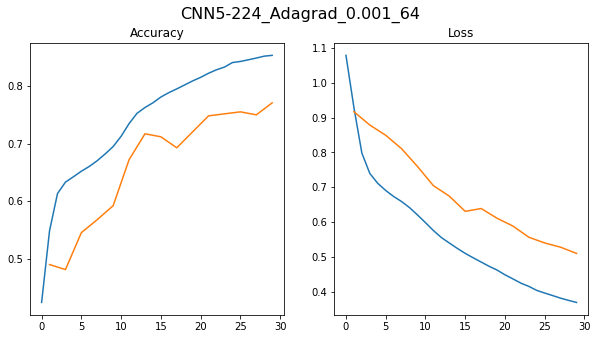

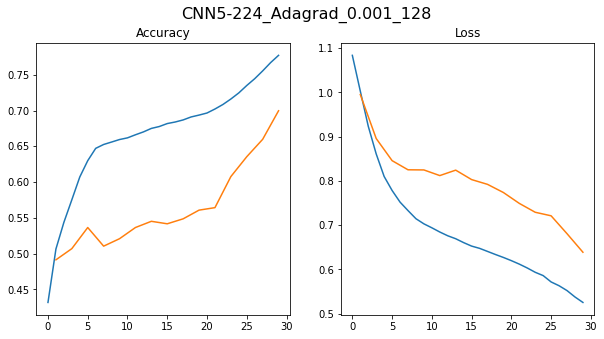

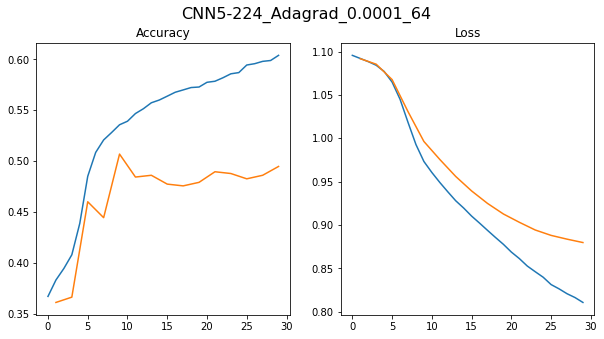

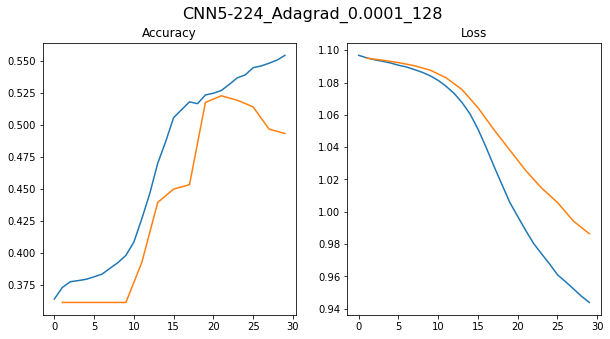

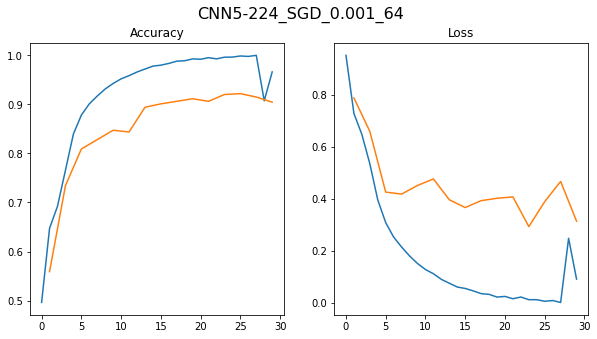

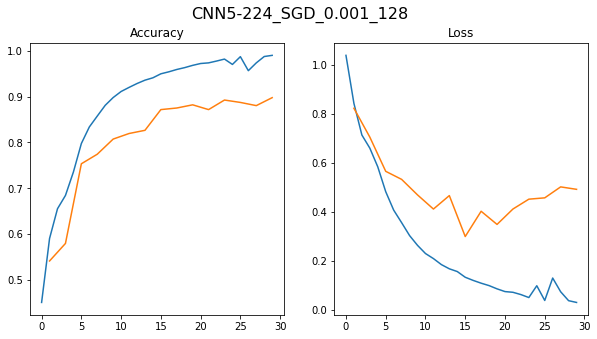

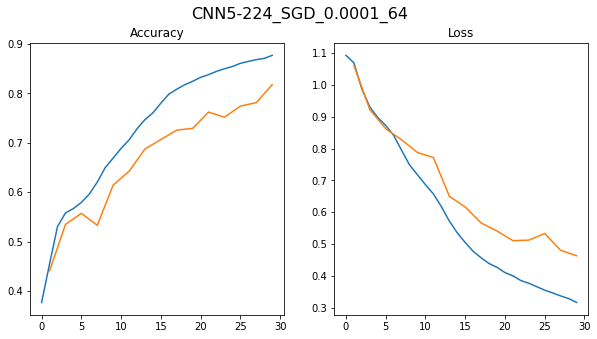

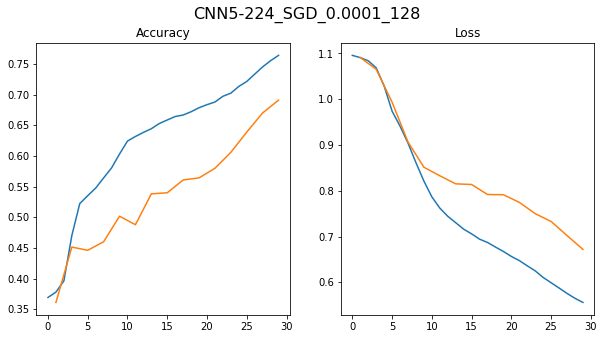

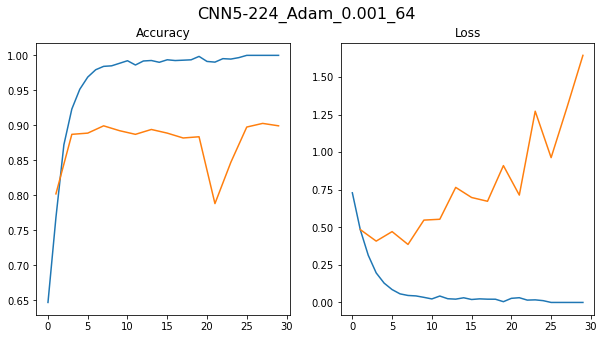

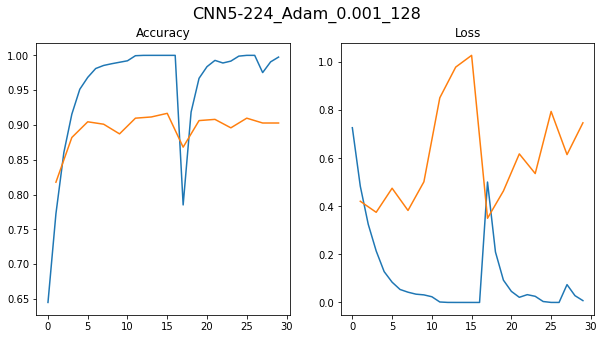

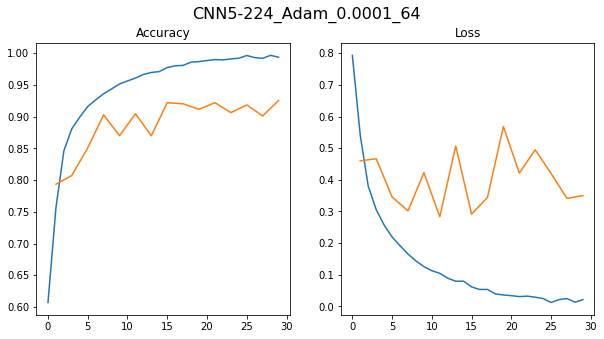

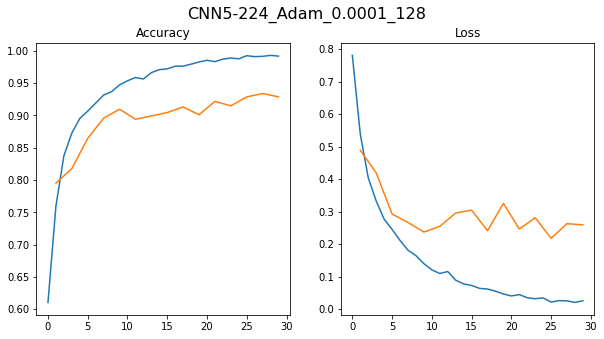

In [ ]:
for model_name in model_names:
  checkpoint_path = os.path.join(os.getcwd(),"models/{}".format(model_name)+"/cp-{epoch:04d}.h5") 
  model_dir = os.path.dirname(checkpoint_path)
  history_dataframe = pd.read_csv(model_dir+'/model_history.csv',sep=',')  
  fig ,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))
  fig.suptitle(model_name, fontsize=16)
  ax1.set_title('Accuracy')
  ax1.plot(history_dataframe['accuracy'])
  ax1.plot(history_dataframe['val_accuracy'][validation_period-1::validation_period])
  ax2.set_title('Loss')
  ax2.plot(history_dataframe['loss'])
  ax2.plot(history_dataframe['val_loss'][validation_period-1::validation_period])
  plt.savefig(os.path.join(model_dir,"{}_plot.pdf".format(model_name)))

###Test Evaluation

In [ ]:
print('Test Evaluation')
tf.random.set_seed(0)
test_samples_for_patch=5
test_dataset=test_dataset_base.batch(1).repeat(test_samples_for_patch)

try:
  test_results
  for model_name in model_names:
    print(model_name)
    print('Test accuracy:',test_results[model_name][1],', Test loss:',test_results[model_name][0])
    print('Score:',3*test_results[model_name][1]-test_results[model_name][0],'\n')
except:
  test_results={}
  test_samples=len([None for batch in test_dataset])
  for model_name in model_names:
    print(model_name)
    test_results[model_name] = trained_models[model_name].evaluate(test_dataset, steps=test_samples)
    t_results={}
    t_results[model_name]=test_results[model_name]
    t_results = pd.DataFrame.from_dict(t_results).T
    t_results.columns=['loss','accuracy']
    t_results = t_results[['accuracy','loss']]
    t_results.to_csv(os.path.join(os.getcwd(),"models/{}/test_results.csv".format(model_name)))
    print('Score:',3*test_results[model_name][1]-test_results[model_name][0])

test_results = pd.DataFrame.from_dict(test_results).T
test_results.columns=['loss','accuracy']
test_results = test_results[['accuracy','loss']]
test_results.to_csv(os.path.join(os.getcwd(),"models/test_results.csv"))

Test Evaluation
CNN5-224_Adagrad_0.001_64
CNN5-224_Adagrad_0.001_64
3200/3200 [==============================] - 8s 2ms/step - loss: 0.4291 - accuracy: 0.8250
Score: 2.0459191501140594
CNN5-224_Adagrad_0.001_128
3200/3200 [==============================] - 8s 2ms/step - loss: 0.5888 - accuracy: 0.7641
Score: 1.7033572793006897
CNN5-224_Adagrad_0.0001_64
3200/3200 [==============================] - 8s 2ms/step - loss: 0.8843 - accuracy: 0.5953
Score: 0.9016571640968323
CNN5-224_Adagrad_0.0001_128
3200/3200 [==============================] - 8s 2ms/step - loss: 0.9700 - accuracy: 0.4875
Score: 0.4925374984741211
CNN5-224_SGD_0.001_64
3200/3200 [==============================] - 8s 2ms/step - loss: 0.2905 - accuracy: 0.9172
Score: 2.4610565900802612
CNN5-224_SGD_0.001_128
3200/3200 [==============================] - 8s 2ms/step - loss: 0.3207 - accuracy: 0.8953
Score: 2.365264117717743
CNN5-224_SGD_0.0001_64
3200/3200 [==============================] - 8s 2ms/step - loss: 0.4254 - accurac

###Tensorboard

In [ ]:
for i,model_name in enumerate(model_names):
  print(i,': ',model_name)

0 :  CNN5-224_Adagrad_0.001_64
1 :  CNN5-224_Adagrad_0.001_128
2 :  CNN5-224_Adagrad_0.0001_64
3 :  CNN5-224_Adagrad_0.0001_128
4 :  CNN5-224_SGD_0.001_64
5 :  CNN5-224_SGD_0.001_128
6 :  CNN5-224_SGD_0.0001_64
7 :  CNN5-224_SGD_0.0001_128
8 :  CNN5-224_Adam_0.001_64
9 :  CNN5-224_Adam_0.001_128
10 :  CNN5-224_Adam_0.0001_64
11 :  CNN5-224_Adam_0.0001_128


In [ ]:
selected_model=0
model_name=list(tensorboard_folders.keys())[selected_model]
path=tensorboard_folders[model_name]
#%tensorboard --logdir "{path}"